# Multiclass Classification Project
## Learning Goals

- How to read different size images from a directory?
- How to implement One-vs-one scheme for Multiclass classification?
- How to use SVM for image classifcation?
 ## 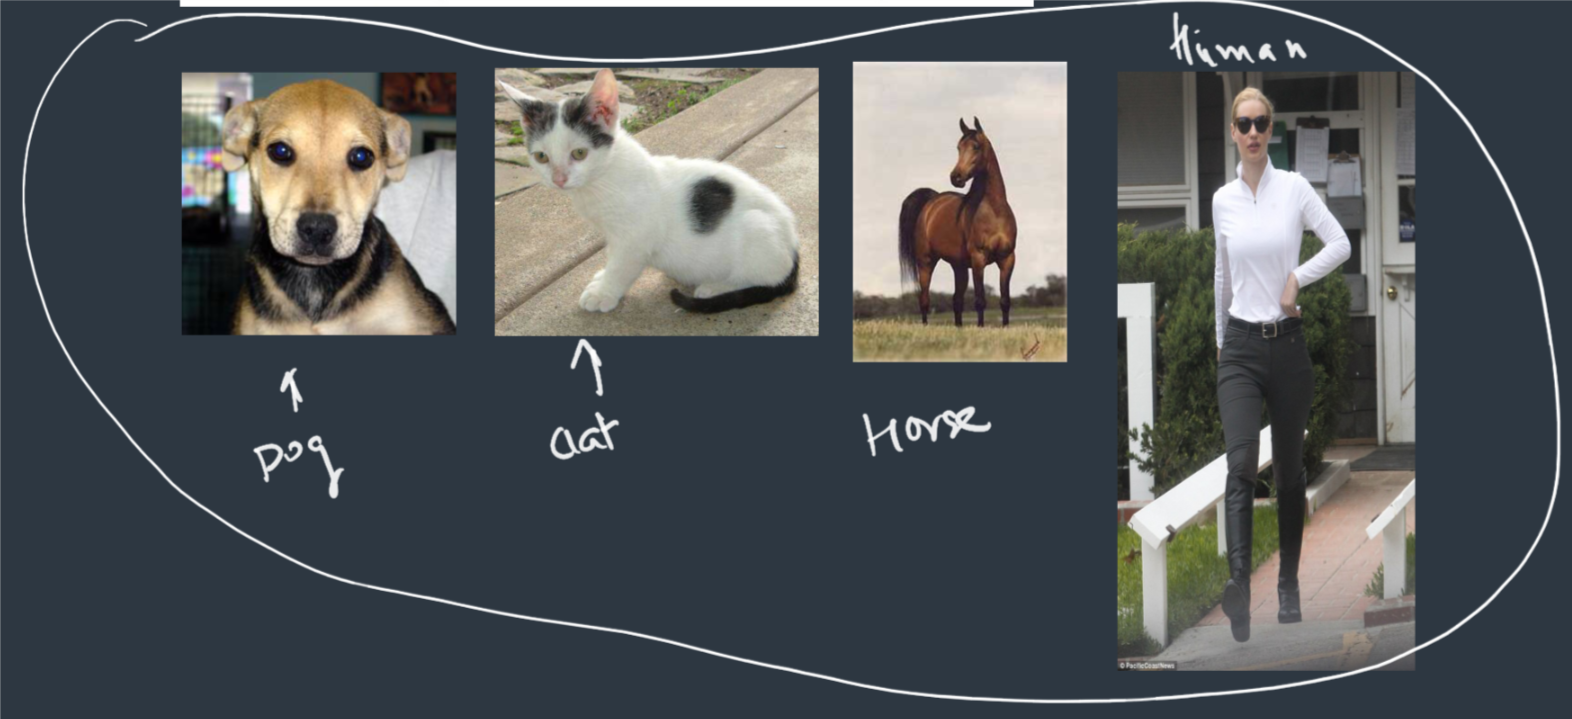

## Dataset Preparation

In [70]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.preprocessing import image

In [71]:
p=Path("./CLASSIMAGES/")
# print(type(p))
dirs=p.glob("*")
labels_dict = {"cat":0,"dog":1,"horse":2,"human":3}
image_data = []
labels = []
for folder_dir in dirs:
    # print(folder_name)
    label = folder_dir.name[:-1]
    print(label)
    for img_path in folder_dir.glob("*.jpg"):
        img=image.load_img(img_path,target_size=(32,32))
        img_array=image.img_to_array(img)
        image_data.append(img_array)
        labels.append(labels_dict[label])
        

dog
cat
human
horse


In [72]:
print(len(image_data))
print(len(labels))

808
808


In [73]:
image_data=np.array(image_data,dtype='float32')/255.0
labels=np.array(labels)
print(labels.shape)
print(image_data.shape)

(808,)
(808, 32, 32, 3)


In [74]:
import random
combined = list(zip(image_data,labels))#zip labels along with there image while shuffling
random.shuffle(combined)
#Unzip
image_data[:],labels[:] = zip(*combined)

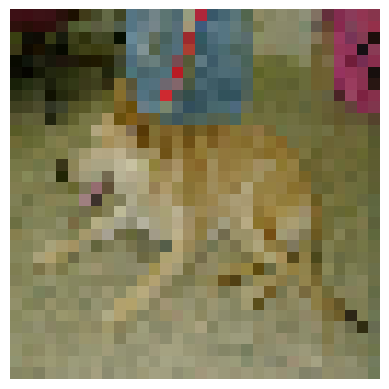

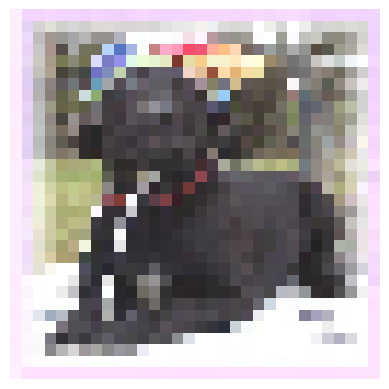

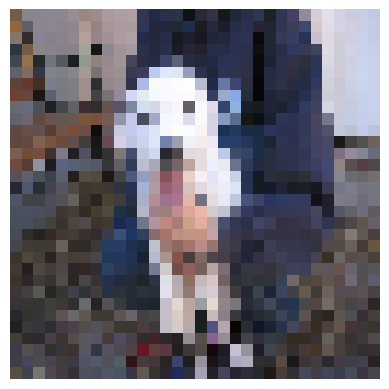

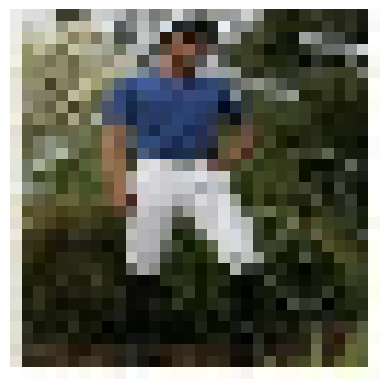

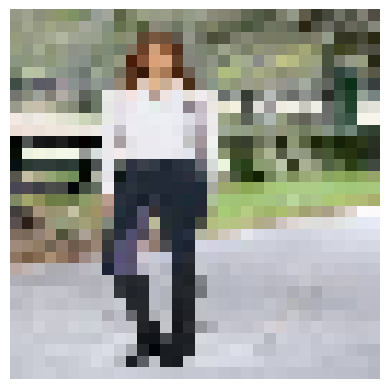

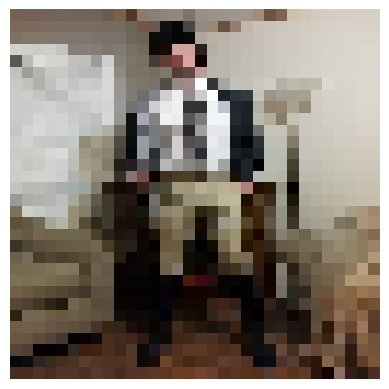

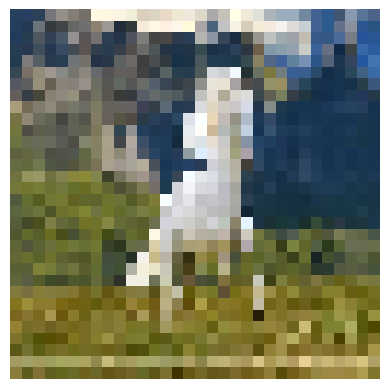

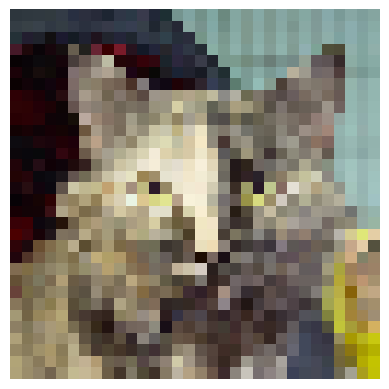

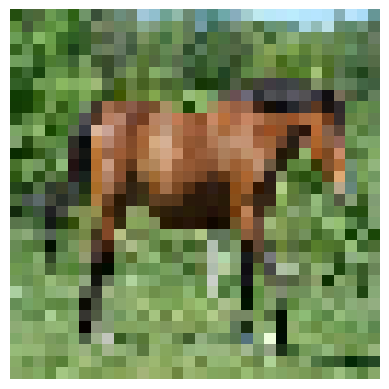

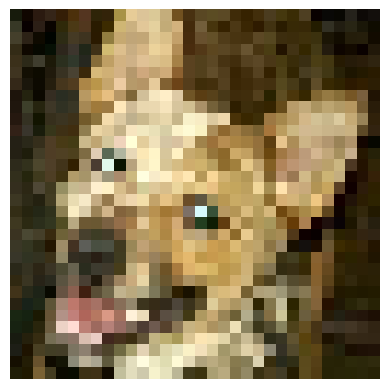

In [75]:
def drawImg(img):
    plt.imshow(img)
    plt.axis("off")
    plt.show()    
    return 

for i in range(10):
    drawImg(image_data[i])

# SVM CLASSIFIER

In [76]:
class SVM:
    def __init__(self,C=1.0):
        self.C = C
        self.W = 0
        self.b = 0
        
    def hingeLoss(self,W,b,X,Y):
        loss  = 0.0
        
        loss += .5*np.dot(W,W.T)
        
        m = X.shape[0]
        
        for i in range(m):
            ti = Y[i]*(np.dot(W,X[i].T)+b)
            loss += self.C *max(0,(1-ti))
            
        return loss[0][0]
    
    def fit(self,X,Y,batch_size=50,learning_rate=0.001,maxItr=500):
        
        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]
        n = learning_rate
        c = self.C
        #Init the model parameters
        W = np.zeros((1,no_of_features))
        bias = 0
        #Training from here...
        losses = []
        for i in range(maxItr):
            #Training Loop
            l = self.hingeLoss(W,bias,X,Y)
            losses.append(l)
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)
            #Batch Gradient DescenT
            for batch_start in range(0,no_of_samples,batch_size):
                #Assume 0 gradient for the batch
                gradw = 0
                gradb = 0
                #Iterate over all examples in the mini batch
                for j in range(batch_start,batch_start+batch_size):
                    if j<no_of_samples:
                        i = ids[j]
                        ti =  Y[i]*(np.dot(W,X[i].T)+bias)
                        
                        if ti>1:
                            gradw += 0
                            gradb += 0
                        else:
                            gradw += c*Y[i]*X[i]
                            gradb += c*Y[i]
                W = W - n*W + n*gradw
                bias = bias + n*gradb  
        
        self.W = W
        self.b = bias
        return W,bias,losses

# DATA CONVERSTION FOR ONE VS ONE CLASSIFICATION

In [77]:
m=image_data.shape[0]
image_data=image_data.reshape((m,-1))
image_data.shape

(808, 3072)

In [78]:
classes=len(np.unique(labels))
classes

4

In [79]:
def classwisedata(x,y):
    data={}
    for i in range(classes):
        data[i]=[]
    for j in range(m):
        data[y[j]].append(x[j])
    for k in data.keys():
        data[k]=np.array(data[k])
    return data

In [80]:
data = classwisedata(image_data,labels)

In [81]:
print(data[1].shape[0],data[2].shape[0],data[3].shape[0],data[0].shape[0])

202 202 202 202


In [82]:
def getDataPairForSvm(d1,d2):
    l1,l2=d1.shape[0],d2.shape[0]
    features=d1.shape[1]
    samples=l1+l2
    data_labels=np.zeros((samples,))
    data_pair=np.zeros((samples,features))
    data_pair[:l1,:]=d1
    data_pair[l1:,:]=d2
    data_labels[:l1]=-1
    data_labels[l1:]=+1
    return data_pair,data_labels

# TRAINING NC2 OR ONE VS ONE SVM

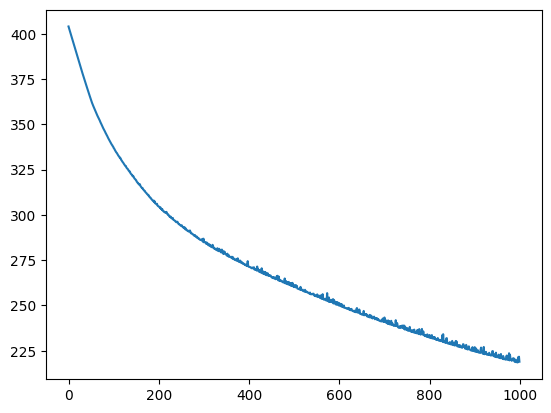

In [83]:
svm=SVM()
xp,yp=getDataPairForSvm(data[0],data[1])
w,b,loss=svm.fit(xp,yp,learning_rate=0.00001,maxItr=1000)
plt.plot(loss)

In [84]:
def trainSVMs(x,y):
    svm_classifiers = {}
    for i in range(classes):
        svm_classifiers[i] = {}
        for j in range(i+1,classes):
            xpair,ypair = getDataPairForSvm(data[i],data[j])
            wts,b,loss = svm.fit(xpair,ypair,learning_rate=0.00001,maxItr=1000)
            svm_classifiers[i][j] = (wts,b)
            plt.plot(loss)
            plt.show()
    return svm_classifiers

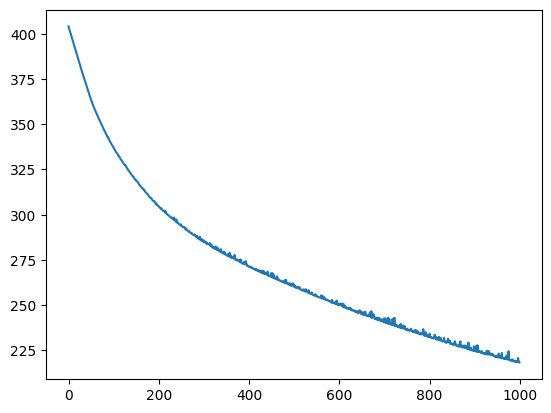

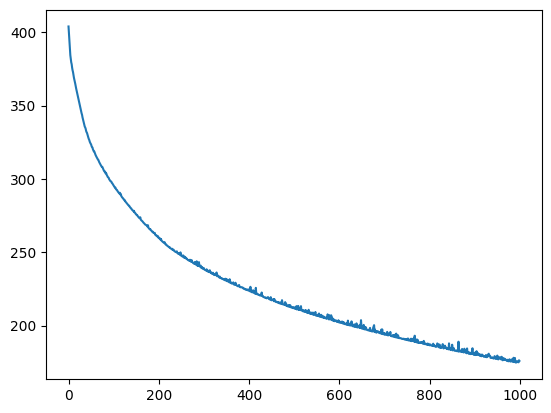

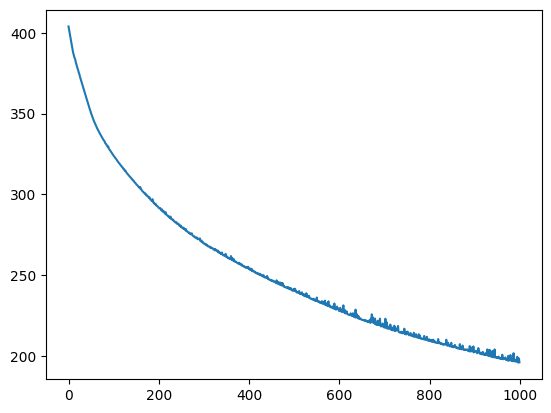

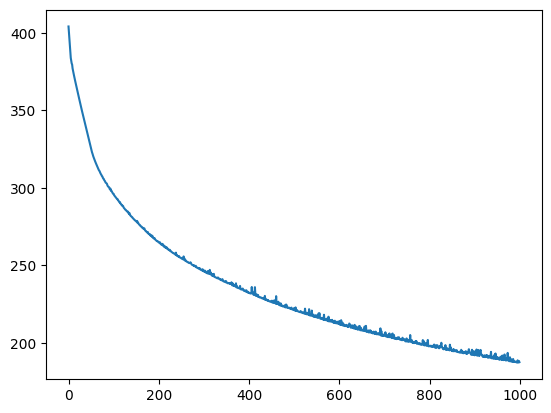

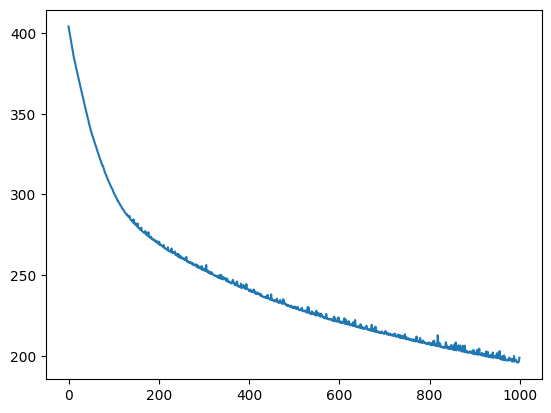

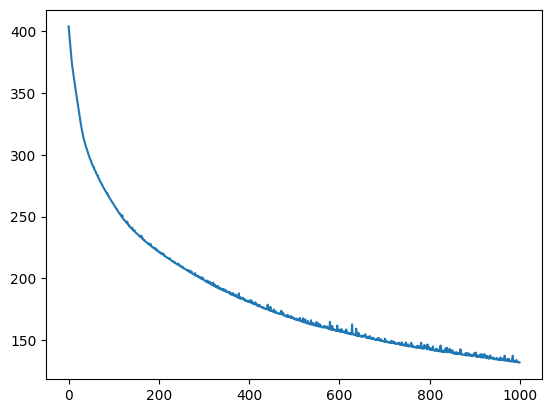

In [85]:
svm_classifiers=trainSVMs(image_data,labels)

In [86]:
svm_classifiers[0][1] # cats dog parameters

(array([[ 0.02558943,  0.02694776,  0.02565195, ..., -0.0010448 ,
         -0.01023242, -0.00332548]]),
 0.010669999999999933)

# PREDICTION

In [87]:
def binaryPredict(x,w,b):
    z  = np.dot(x,w.T) + b
    if z>=0:
        return 1
    else:
        return -1

In [88]:
def predict(x):
    count = np.zeros((classes,))
    for i in range(classes):
        for j in range(i+1,classes):
            w,b = svm_classifiers[i][j]
            #Take a majority prediction 
            z = binaryPredict(x,w,b)
            if(z==1):
                count[j] += 1
            else:
                count[i] += 1
    
    final_prediction = np.argmax(count)
    #print(count)
    return final_prediction

In [89]:
print(labels[1])
print(predict(image_data[1]))

1
1


In [90]:
def accuracy(x,y):
    count = 0
    for i in range(x.shape[0]):
        prediction = predict(x[i])
        if(prediction==y[i]):
            count += 1
            
    return count/x.shape[0]

In [91]:
accuracy(image_data,labels)

0.5928217821782178

# SVM FROM SKLEARN

In [92]:
from sklearn import svm

In [99]:
svm_classifier=svm.SVC(kernel='linear',C=1.10)
svm_classifier.fit(image_data,labels)
svm_classifier.score(image_data,labels)

0.6373762376237624